<a href="https://colab.research.google.com/github/ApatiaGimenez/TP-final-P.A/blob/main/tp2_Sistemas_de_recomendacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de recomendación: **películas** 🍿📺

## EDA

In [ ]:
#Librerías
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
users = pd.read_csv('ratings_small.csv')
movies = pd.read_csv('movies_metadata.csv')

<ipython-input-3-23ba986cca28>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('movies_metadata.csv')


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
indices_a_eliminar = [19729, 29502, 35586, 19730, 29503, 35587]
#los primeros tres índices corresponden a filas cuyo id es erróneo (formato fecha), y los últimos tres a películas sin título
movies = movies.drop(indices_a_eliminar)

In [ ]:
#Conversión de tipo de datos del dataset movies
#int
movies['id'] = movies['id'].astype(int)
movies['budget'] = movies['budget'].astype(int)
#float
movies['popularity'] = movies['popularity'].astype(float)
#string
cadenas = ['original_language', 'original_title', 'overview', 'status', 'tagline', 'title']
movies[cadenas] = movies[cadenas].astype(str)
#date
movies['release_date'] = pd.to_datetime(movies['release_date'])
#bool
booleanas = ['adult', 'video']
movies[booleanas] = movies[booleanas].astype(bool)

In [ ]:
#Función para convertir la lista de diccionarios a una cadena de géneros (para desglosar la columna "genres")
def obtener_generos(lista_genres):
    #Si la columna está en formato string, convertirla a lista de diccionarios
    if isinstance(lista_genres, str):
        lista_genres = ast.literal_eval(lista_genres)
    #Obtener los nombres de los géneros
    return ', '.join([gen['name'] for gen in lista_genres])
movies['genres'] = movies['genres'].apply(obtener_generos)

#Ídem pero para el país de producción. Solamente se obtiene la abreviación del país del diccionario
def obtener_pais(lista_pais):
    #Si la columna está en formato string, convertirla a lista de diccionarios
    if isinstance(lista_pais, str):
        lista_pais = ast.literal_eval(lista_pais)
    #Obtener el código del país (iso_3166_1)
    return lista_pais[0]['iso_3166_1'] if lista_pais else None
movies['production_countries'] = movies['production_countries'].apply(obtener_pais)

In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,True,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"Animation, Comedy, Family",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,nan,Toy Story,False,7.7,5415.0
1,True,NaN,65000000,"Adventure, Fantasy, Family",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,True,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"Romance, Comedy",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,True,NaN,16000000,"Comedy, Drama, Romance",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,True,"{'id': 96871, 'name': 'Father of the Bride Col...",0,Comedy,NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45460 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45460 non-null  bool          
 1   belongs_to_collection  4490 non-null   object        
 2   budget                 45460 non-null  int64         
 3   genres                 45460 non-null  object        
 4   homepage               7778 non-null   object        
 5   id                     45460 non-null  int64         
 6   imdb_id                45443 non-null  object        
 7   original_language      45460 non-null  object        
 8   original_title         45460 non-null  object        
 9   overview               45460 non-null  object        
 10  popularity             45460 non-null  float64       
 11  poster_path            45077 non-null  object        
 12  production_companies   45460 non-null  object        
 13  produc

In [ ]:
#Dimensiones de los datasets
print(f'users: {users.shape}')
print(f'movies: {movies.shape}')

users: (100004, 4)
movies: (45460, 24)


*   👤: El dataset **users** contiene 100.004 calificaciones de 700 (dato de Kaggle).
*   🎞️: El dataset **movies** contiene información de 45460 películas.

### Valores nulos

In [ ]:
#Análisis de NAs
print('NAs en users')
print(users.isnull().sum(), '\n')
print('NAs en movies')
print(movies.isnull().sum())

NAs en users
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

NAs en movies
adult                        0
belongs_to_collection    40970
budget                       0
genres                       0
homepage                 37682
id                           0
imdb_id                     17
original_language            0
original_title               0
overview                     0
popularity                   0
poster_path                383
production_companies         0
production_countries      6282
release_date                84
revenue                      0
runtime                    257
spoken_languages             0
status                       0
tagline                      0
title                        0
video                        0
vote_average                 0
vote_count                   0
dtype: int64


In [ ]:
movies = movies.drop(columns=['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'video'])

In [ ]:
users = users.drop(columns=['timestamp'])

### Valores atípicos

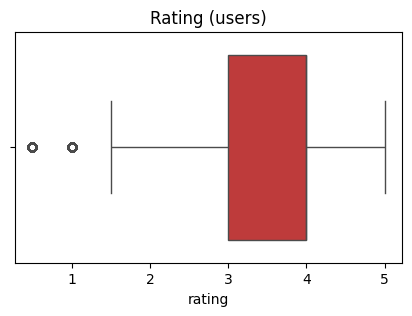

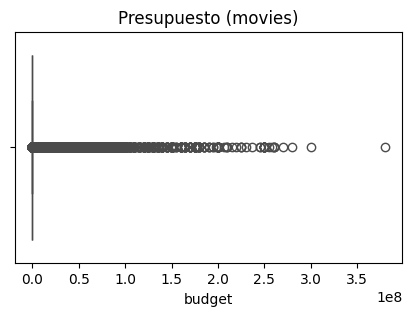

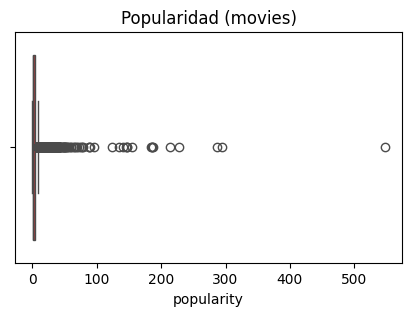

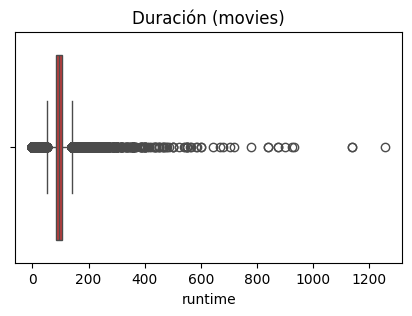

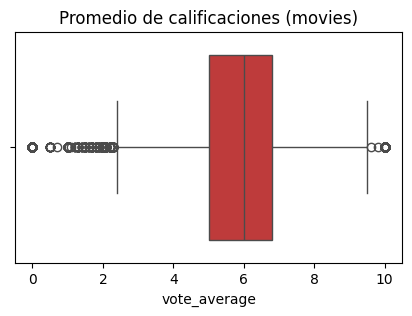

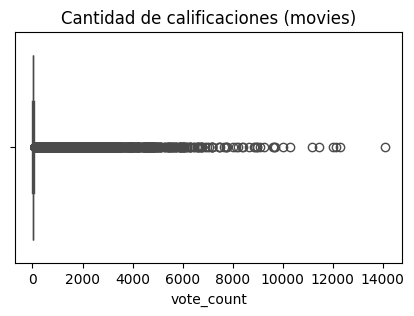

In [ ]:
#Análisis de outliers

#Boxplot para la columna 'rating' de useres
plt.figure(figsize=(5, 3))
sns.boxplot(x=users['rating'], color='#d42525')
plt.title('Rating (users)')
plt.show()

#Boxplot para ciertas columnas de movies
#budget
plt.figure(figsize=(5, 3))
sns.boxplot(x=movies['budget'], color='#d42525')
plt.title('Presupuesto (movies)')
plt.show()
#popularity
plt.figure(figsize=(5, 3))
sns.boxplot(x=movies['popularity'], color='#d42525')
plt.title('Popularidad (movies)')
plt.show()
#runtime
plt.figure(figsize=(5, 3))
sns.boxplot(x=movies['runtime'], color='#d42525')
plt.title('Duración (movies)')
plt.show()
#vote_average
plt.figure(figsize=(5, 3))
sns.boxplot(x=movies['vote_average'], color='#d42525')
plt.title('Promedio de calificaciones (movies)')
plt.show()
#vote_count
plt.figure(figsize=(5, 3))
sns.boxplot(x=movies['vote_count'], color='#d42525')
plt.title('Cantidad de calificaciones (movies)')
plt.show()

**Cantidad de películas clasificadas por cada usuario**:

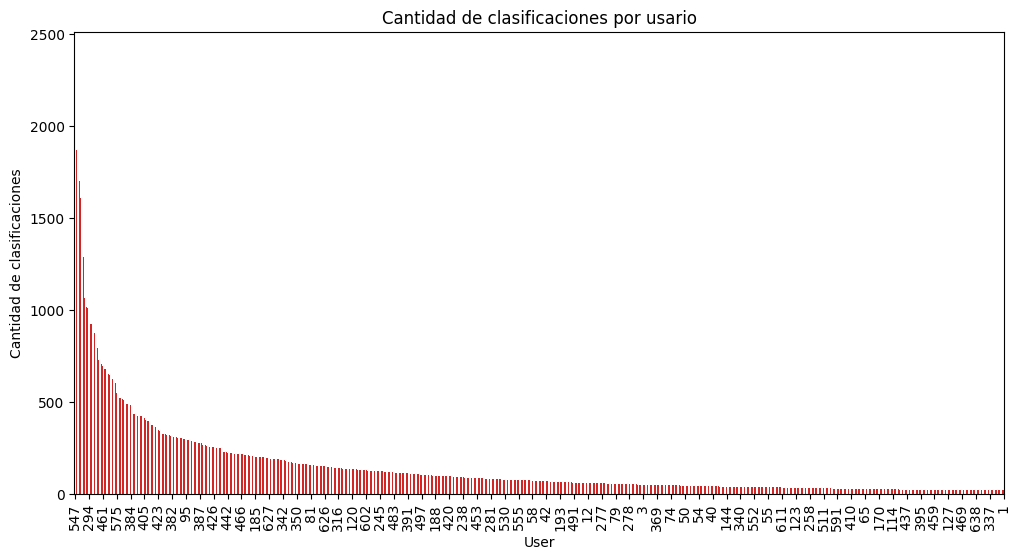

In [ ]:
#Cantidad de ratings por usuario
ratings_count_users = users['userId'].value_counts()

#Gráfico de barras
plt.figure(figsize=(12, 6))
ratings_count_users.plot(kind='bar',color='#d42525')
plt.xlabel('User')
plt.ylabel('Cantidad de clasificaciones')
plt.title('Cantidad de clasificaciones por usario')
n = 10
plt.xticks(range(len(ratings_count_users))[::n], ratings_count_users.index[::n], rotation=90)
plt.show()

**Top 10 películas con la clasificación más alta:**

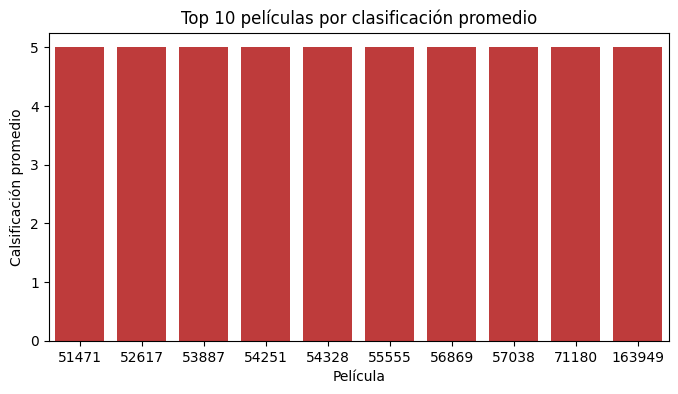

In [ ]:
#Agrupar por movieId y calcular el promedio de puntuaciones
movie_avg_ratings = users.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(10)

#Gráfico de barras
plt.figure(figsize=(8, 4))
sns.barplot(x=movie_avg_ratings.index, y=movie_avg_ratings.values, color='#d42525')
plt.xlabel('Película')
plt.ylabel('Calsificación promedio')
plt.title('Top 10 películas por clasificación promedio')
plt.show()

Puede que tengan average 5 porque fueron clasificadas una sola vez.

**Películas clasificadas v.s. usuarios:**

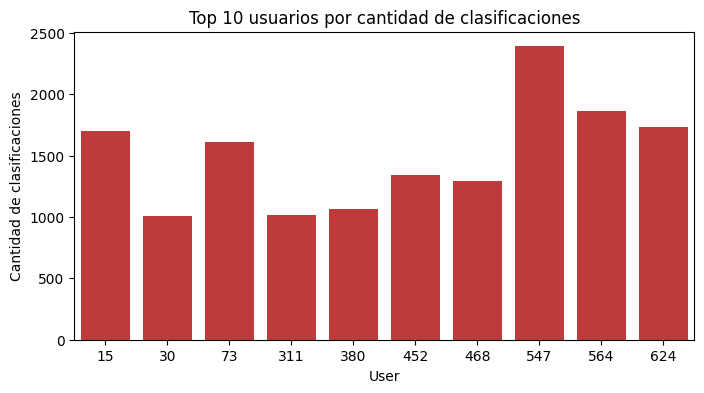

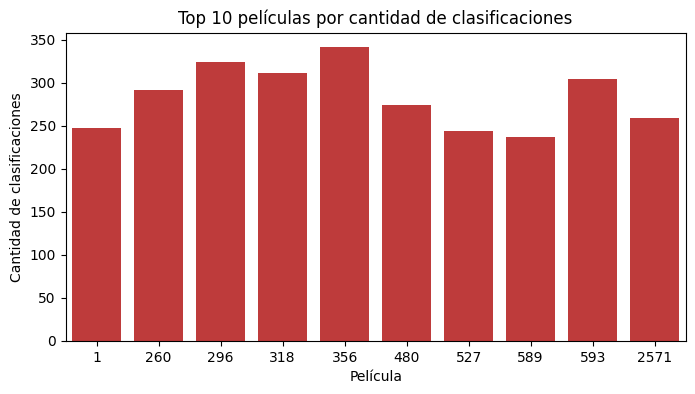

In [ ]:
#Cantidad de películas clasificadas por cada usuario
user_rating_counts = users['userId'].value_counts().head(10)

#Cantidad de usuarios que clasificaron cada película
movie_rating_counts = users['movieId'].value_counts().head(10)

#Gráfico de barras para los usuarios
plt.figure(figsize=(8, 4))
sns.barplot(x=user_rating_counts.index, y=user_rating_counts.values, color='#d42525')
plt.xlabel('User')
plt.ylabel('Cantidad de clasificaciones')
plt.title('Top 10 usuarios por cantidad de clasificaciones')
plt.show()

#Gráfico de barras para las películas
plt.figure(figsize=(8, 4))
sns.barplot(x=movie_rating_counts.index, y=movie_rating_counts.values, color='#d42525')
plt.xlabel('Película')
plt.ylabel('Cantidad de clasificaciones')
plt.title('Top 10 películas por cantidad de clasificaciones')
plt.show()

**Top 10 agrupación de géneros:**

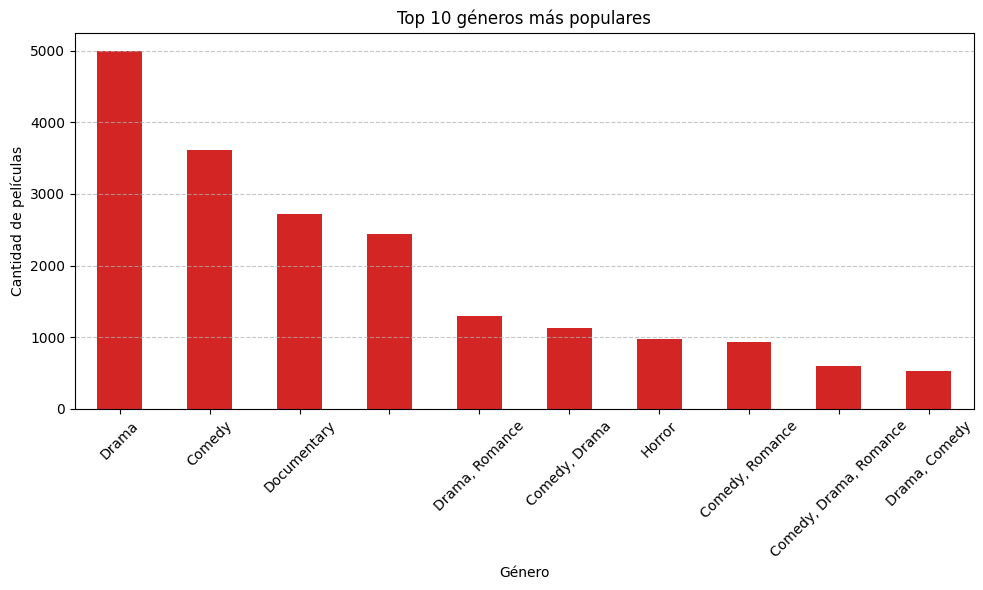

In [ ]:
#Contar películas por género
genre_counts = movies['genres'].value_counts()

#Seleccionar los 10 géneros más populares
top_genres = genre_counts.head(10)

#Gráfico de barras
plt.figure(figsize=(10, 6))
top_genres.plot(kind='bar', color='#d42525')
plt.title('Top 10 géneros más populares')
plt.xlabel('Género')
plt.ylabel('Cantidad de películas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Filtros colaborativos

In [ ]:
data = {}

for _, row in users.iterrows():
    user = row['userId']
    movie = row['movieId']
    rating = row['rating']

    if user not in data:
        data[user] = {}

    data[user][movie] = rating

In [ ]:
df_data=pd.DataFrame(data).transpose()
df_data

,31.0,1029.0,1061.0,1129.0,1172.0,1263.0,1287.0,1293.0,1339.0,1343.0,...,134528.0,134783.0,137595.0,138204.0,60832.0,64997.0,72380.0,129.0,4736.0,6425.0
1.0,2.5,3.0,3.0,2.0,4.0,2.0,2.0,2.0,3.5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
669.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Hay un total de 671 users y 9066 movies.

Distancias:

In [ ]:
#Distancia euclidiana entre usuarios
def euclidean_similarity(person1, person2):

	common_ranked_items = [itm for itm in data[person1] if itm in data[person2]]
	rankings = [(data[person1][itm], data[person2][itm]) for itm in common_ranked_items]
	distance = [pow(rank[0] - rank[1], 2) for rank in rankings]

	return 1 / (1 + sum(distance))

#Distancia euclidiana entre ítems
def euclidean_similarity_item(item1_ratings, item2_ratings):
    common_users = set(item1_ratings.keys()).intersection(set(item2_ratings.keys()))
    if not common_users:
        return 0
    distances = [np.power(item1_ratings[user] - item2_ratings[user], 2) for user in common_users]
    return 1 / (1 + np.sqrt(np.sum(distances)))

In [ ]:
#Distancia por correlación de Pearson
def pearson_similarity(person1, person2):

	common_ranked_items = [itm for itm in data[person1] if itm in data[person2]]

	n = len(common_ranked_items)

	s1 = sum([data[person1][item] for item in common_ranked_items])
	s2 = sum([data[person2][item] for item in common_ranked_items])

	ss1 = sum([pow(data[person1][item], 2) for item in common_ranked_items])
	ss2 = sum([pow(data[person2][item], 2) for item in common_ranked_items])

	ps = sum([data[person1][item] * data[person2][item] for item in common_ranked_items])

	num = n * ps - (s1 * s2)

	den = math.sqrt((n * ss1 - math.pow(s1, 2)) * (n * ss2 - math.pow(s2, 2)))

	return (num / den) if den != 0 else 0

Función de extracción de títulos a partir de un id:

In [ ]:
def get_movie_title(movie_id, movies_df):
    #Buscar la película con el id especificado
    movie = movies_df[movies_df['id'] == movie_id]
    #Verificar si se encontró la película
    if not movie.empty:
        return movie['title'].values[0]
    else:
        return f"No se encontró una película con el id {movie_id}."

Función para recomendar top n películas

In [ ]:
def n_recomendaciones(recomendaciones,n):
  top_n_items = sorted(recomendaciones.items(), key=lambda item: item[1], reverse=True)[:n]
  top_n_dict = dict(top_n_items)

  return top_n_dict

### Basados en memoria

**User-User**

In [ ]:
#Función para recomendar películas
def user_recommend(person, bound, data, similarity=pearson_similarity):
	scores = [(similarity(person, other), other) for other in data if other != person]

	scores.sort()
	scores.reverse()
	scores = scores[0:bound]

	recomms = {}

	for sim, other in scores:
		ranked = data[other]

		for itm in ranked:
			if itm not in data[person]:
				weight = sim * ranked[itm]

				if itm in recomms:
					s, weights = recomms[itm]
					recomms[itm] = (s + sim, weights + [weight])
				else:
					recomms[itm] = (sim, [weight])

  #Normalizar
	for r in recomms:
		sim, item = recomms[r]
		recomms[r] = sum(item) / sim

	return recomms

In [ ]:
rec = user_recommend(2, 10, data)
n_recomendaciones(rec, 1)

{27904.0: 5.0}

In [ ]:
movie_id = 27904
title = get_movie_title(movie_id, movies)
print("Título de la película:", title)

Título de la película: Syndromes and a Century


Evaluar la recomendación

In [ ]:
train_data, test_data = train_test_split(users, test_size=0.2, random_state=42)

train_data_dict = {}
test_data_dict = {}

for _, row in train_data.iterrows():
    user = row['userId']
    movie = row['movieId']
    rating = row['rating']

    if user not in train_data_dict:
        train_data_dict[user] = {}

    train_data_dict[user][movie] = rating

for _, row in test_data.iterrows():
    user = row['userId']
    movie = row['movieId']
    rating = row['rating']

    if user not in test_data_dict:
        test_data_dict[user] = {}

    test_data_dict[user][movie] = rating

In [ ]:
def evaluate_recommender(train_data_dict, test_data_dict, similarity_func):
    predictions = []

    for user in test_data_dict:
        recommendations = user_recommend(user, 20, train_data_dict, similarity_func)
        for movie in test_data_dict[user]:
            if movie in recommendations:
                predictions.append((test_data_dict[user][movie], recommendations[movie]))
    return predictions

In [ ]:
predictions = evaluate_recommender(train_data_dict, test_data_dict, euclidean_similarity)

actual = [rating for rating, _ in predictions]
predicted = [pred for _, pred in predictions]

actual = np.array(actual)
predicted = np.array(predicted)

mask = ~np.isnan(predicted)
actual = actual[mask]
predicted = predicted[mask]

#Calcular R^2
r2 = r2_score(actual, predicted)
print(f"Coeficiente R^2 del SR: {r2}")

Coeficiente R^2 del SR: 0.6317102926095252


In [ ]:
import matplotlib.pyplot as plt

#Datos para el gráfico
items = list(rec.keys())  #Ítems recomendados
sims = [rec[item] for item in rec]  #Valores de similitud
weights = list(rec.values())  #Suma de los pesos

#Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(sims, weights, alpha=0.7, c='#3c9ade', edgecolors='k')
plt.axvline(0, color='#fd6220', linestyle='--', label='Similitud = 0')  # Línea para sim = 0
plt.title("Relación entre Similitud y Pesos de Recomendación")
plt.xlabel("Similitud acumulada (sim)")
plt.ylabel("Suma de Pesos (weights)")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'rec' is not defined

**Ítem-Ítem**

In [ ]:
def average_rating(movie_id, data):
    total_rating = 0
    count = 0

    for user in data:
        if movie_id in data[user]:
            total_rating += data[user][movie_id]
            count += 1

    return total_rating / count if count > 0 else 0

In [ ]:
def item_recommend(user, bound, data, similarity_func=euclidean_similarity_item):
    #Top n ítems mejor clasificados por el usuario
    favorite_items = sorted(data[user].items(), key=lambda x: x[1], reverse=True)[:bound]
    favorite_item_ids = [item[0] for item in favorite_items]

    #Estructura de datos a formato item-centered
    item_data = {}
    for usr in data:
        for item, rating in data[usr].items():
            if item not in item_data:
                item_data[item] = {}
            item_data[item][usr] = rating

    #Similitud entre los ítems favoritos y todos los demás ítems
    item_similarities = {}
    for item in favorite_item_ids:
        item_similarities[item] = [(similarity_func(item_data[item], item_data[other]), other) for other in item_data if other != item]

    recommendations = {}

    #Recomendar ítems similares que el usuario aún no ha interactuado
    for item in favorite_item_ids:
        for sim, other in item_similarities[item]:
            if other not in data[user]:  # filtrar ítems que el usuario ya ha visto
                weight = sim * average_rating(other,data)
                if other in recommendations:
                    s, weights = recommendations[other]
                    recommendations[other] = (s + sim, weights + [weight])
                else:
                    recommendations[other] = (sim, [weight])

    #Normalizar los puntajes de recomendación (promedio ponderado de similitudes)
    # for item in recommendations:
    #     sim, weights = recommendations[item]
    #     recommendations[item] = sum(weights) / sim
    for item in recommendations:
      sim, weights = recommendations[item]
      #print(f"Procesando ítem {item}, similitud acumulada: {sim}")
      if sim > 0:
          recommendations[item] = sum(weights) / sim
      else:
          #print(f"Advertencia: Similitud es 0 para ítem {item}")
          recommendations[item] = 0

    return recommendations

In [ ]:
rec = item_recommend(4,7,data,euclidean_similarity_item)
n_recomendaciones(rec, 1)

{5062.0: 5.000000000000001}

In [ ]:
movie_id = 5062
title = get_movie_title(movie_id, movies)
print("Título de la película:", title)

Título de la película: The Inquisitor


Evaluar la recomendación

In [ ]:
train_data, test_data = train_test_split(users, test_size=0.2, random_state=42)

train_data_dict = {}
test_data_dict = {}

for _, row in train_data.iterrows():
    user = row['userId']
    movie = row['movieId']
    rating = row['rating']

    if user not in train_data_dict:
        train_data_dict[user] = {}

    train_data_dict[user][movie] = rating

for _, row in test_data.iterrows():
    user = row['userId']
    movie = row['movieId']
    rating = row['rating']

    if user not in test_data_dict:
        test_data_dict[user] = {}

    test_data_dict[user][movie] = rating

In [ ]:
def evaluate_recommender(train_data_dict, test_data_dict, similarity_func, top_n=5):
    predictions = []

    for user in test_data_dict:
        recommendations = item_recommend(user, top_n, train_data_dict, similarity_func)
        recommended_movies = set(recommendations.keys())  #Películas recomendadas

        #Solo comparar las películas en el conjunto de prueba que fueron recomendadas
        for movie in test_data_dict[user]:
            if movie in recommended_movies:
                predictions.append((test_data_dict[user][movie], recommendations[movie]))

    return predictions

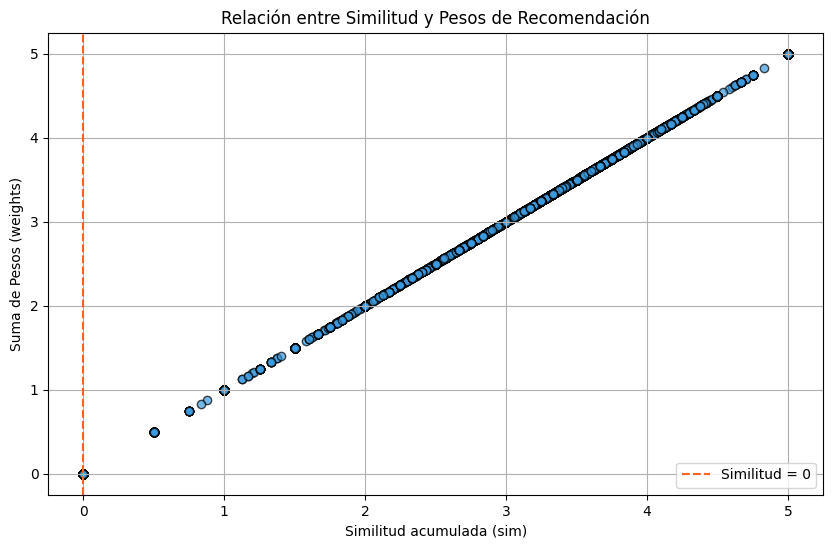

In [ ]:
import matplotlib.pyplot as plt

#Datos para el gráfico
items = list(rec.keys())  #Ítems recomendados
sims = [rec[item] for item in rec]  #Valores de similitud
weights = list(rec.values())  #Suma de los pesos

#Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(sims, weights, alpha=0.7, c='#3c9ade', edgecolors='k')
plt.axvline(0, color='#fd6220', linestyle='--', label='Similitud = 0')  # Línea para sim = 0
plt.title("Relación entre Similitud y Pesos de Recomendación")
plt.xlabel("Similitud acumulada (sim)")
plt.ylabel("Suma de Pesos (weights)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predictions = evaluate_recommender(train_data_dict, test_data_dict, euclidean_similarity_item)

actual = [rating for rating, _ in predictions]
predicted = [pred for _, pred in predictions]

actual = np.array(actual)
predicted = np.array(predicted)

mask = ~np.isnan(predicted)
actual = actual[mask]
predicted = predicted[mask]

#Calcular R^2
r2 = r2_score(actual, predicted)
print(f"Coeficiente R^2 del sistema de recomendación: {r2}")

KeyboardInterrupt: 

### Basados en modelos

U= matriz de usuarios | Vt= matriz de productos (peliculas)

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357297 sha256=441e3b1518a566d149cc08965ce19d89cbaadf7dba31273d2ffb8071edc7adb8
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader, SVD
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Supongamos que data es un diccionario en este formato:
# data = {user1: {item1: rating1, item2: rating2, ...}, user2: {...}, ...}

# Convertimos los datos a una lista de tuplas
rating_data = [(user, item, rating) for user, items in data.items() for item, rating in items.items()]

# Creamos un DataFrame
rating_df = pd.DataFrame(rating_data, columns=['user', 'item', 'rating'])

# Creamos un objeto Reader
reader = Reader(rating_scale=(1, 5))

# Cargamos los datos en un objeto Dataset
data = Dataset.load_from_df(rating_df[['user', 'item', 'rating']], reader=reader)

# Hiperparámetros
param_grid = {
    'n_factors': [50, 100, 150, 200, 299],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# Realizar la Grid Search
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
grid_search.fit(data)

# Ver el mejor modelo encontrado
print(f"Mejores parámetros: {grid_search.best_params}")
print(f"Mejor RMSE: {grid_search.best_score['rmse']}")
print(f"Mejor MAE: {grid_search.best_score['mae']}")

# Obtener el modelo con los mejores parámetros
best_model = grid_search.best_estimator['rmse']

# Entrenamos el modelo con el conjunto completo
trainset = data.build_full_trainset()
best_model.fit(trainset)

# Generamos predicciones en el conjunto de prueba
testset = trainset.build_testset()
predictions = best_model.test(testset)

# Calcular métricas adicionales
y_true = np.array([pred.r_ui for pred in predictions])
y_pred = np.array([pred.est for pred in predictions])

# R²
ss_total = np.sum((y_true - np.mean(y_true))**2)
ss_residual = np.sum((y_true - y_pred)**2)
r2 = 1 - (ss_residual / ss_total)
print(f"R²: {r2}")

# MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape}%")


Mejores parámetros: {'rmse': {'n_factors': 100, 'lr_all': 0.01, 'reg_all': 0.2}, 'mae': {'n_factors': 100, 'lr_all': 0.01, 'reg_all': 0.2}}
Mejor RMSE: 0.8941173524612803
Mejor MAE: 0.6903190389774325
R²: 0.3780835561225826
MAPE: 28.28447706906631%


In [ ]:
# from surprise.model_selection import GridSearchCV
from surprise import KNNBasic
# from surprise import accuracy
# import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'k': [10, 20, 30, 40, 50],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False]}}

# Realizar la búsqueda de cuadrícula con múltiples métricas
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae', 'mse'], cv=3)  # Usamos KNNBasic como modelo
grid_search.fit(data)

# Ver el mejor modelo encontrado
print(f"Mejores parámetros: {grid_search.best_params}")
print(f"Mejor RMSE: {grid_search.best_score['rmse']}")
print(f"Mejor MAE: {grid_search.best_score['mae']}")
print(f"Mejor MSE: {grid_search.best_score['mse']}")

# Obtener el modelo con los mejores parámetros y hacer predicciones
best_model = grid_search.best_estimator['rmse']

# Calcular R² y MAPE usando el mejor modelo
trainset = data.build_full_trainset()
testset = trainset.build_testset()
best_model.fit(trainset)
predictions = best_model.test(testset)

# Calcular R² (Coeficiente de Determinación)
y_true = np.array([pred.r_ui for pred in predictions])  # Usamos 'r_ui' para las calificaciones reales
y_pred = np.array([pred.est for pred in predictions])    # Usamos 'est' para las calificaciones predichas

ss_total = np.sum((y_true - np.mean(y_true))**2)
ss_residual = np.sum((y_true - y_pred)**2)
r2 = 1 - (ss_residual / ss_total)
print(f"R²: {r2}")

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape}%")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Comput

## Filtros basados en contenido

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
movies_reduced = movies.head(20000)

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
genres_matrix = tfidf.fit_transform(movies_reduced['genres'])
genres_matrix.shape

(20000, 22)

In [ ]:
tfidf.vocabulary_

{'animation': 2,
 'comedy': 3,
 'family': 7,
 'adventure': 1,
 'fantasy': 8,
 'romance': 16,
 'drama': 6,
 'action': 0,
 'crime': 4,
 'thriller': 18,
 'horror': 12,
 'history': 11,
 'science': 17,
 'fiction': 9,
 'mystery': 15,
 'war': 20,
 'foreign': 10,
 'music': 14,
 'documentary': 5,
 'western': 21,
 'tv': 19,
 'movie': 13}

In [ ]:
doc = 0
feature_index = genres_matrix[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [genres_matrix[doc, x] for x in feature_index])

In [ ]:
feature_names = tfidf.get_feature_names_out()
tfidf_scores_sorted=[]
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    tfidf_scores_sorted.append([w,s])
    print(w,s)
tfidf_scores_sorted

animation 0.7178685753845186
comedy 0.34459857274712663
family 0.6049103504950507


[['animation', 0.7178685753845186],
 ['comedy', 0.34459857274712663],
 ['family', 0.6049103504950507]]

In [ ]:
tfidf_scores_sorted_df=pd.DataFrame(tfidf_scores_sorted)
tfidf_scores_sorted_df.columns=['token','val']
tfidf_scores_sorted_df.sort_values(by='val',ascending=False,inplace=True)
tfidf_scores_sorted_df.head(5)

,token,val
0,animation,0.717869
2,family,0.604910
1,comedy,0.344599


In [ ]:
similarity_matrix = cosine_similarity(genres_matrix, genres_matrix) #Similitud coseno

In [ ]:
def recommend_movie_based_on_genre(movie_input,n=10):
  movie_index = movies_reduced.loc[movies_reduced.title==movie_input,:].index[0]

  similarity_score = list(enumerate(similarity_matrix[movie_index-1]))
  similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
  similarity_score = similarity_score[1:n]

  movie_indices = [i[0] for i in similarity_score]

  return (movies_reduced[['id','title','genres']].iloc[movie_indices])

In [ ]:
recommend_movie_based_on_genre('Jumanji')

,id,title,genres
695,12233,Oliver & Company,"Animation, Comedy, Family"
727,532,A Close Shave,"Family, Animation, Comedy"
1110,531,The Wrong Trousers,"Animation, Comedy, Family"
1718,40688,Meet the Deedles,"Animation, Comedy, Family"
1939,9994,The Great Mouse Detective,"Comedy, Animation, Family"
2453,16508,Doug's 1st Movie,"Animation, Family, Comedy"
2997,863,Toy Story 2,"Animation, Comedy, Family"
3309,54825,Creature Comforts,"Animation, Comedy, Family"
3629,7443,Chicken Run,"Animation, Comedy, Family"


In [ ]:
# users['movieId'] = users['movieId'].astype(str)
# movies['id'] = movies['id'].astype(str)
# import pandas as pd
# movies['id'] = movies['id'].astype(str)
# users['movieId'] = users['movieId'].astype(str)
# missing_ids = users[users['movieId'].isin(movies['id'])]
# #print(missing_ids)
# users = users[~users['movieId'].isin(missing_ids)]

In [ ]:
# users.shape

(100004, 3)

In [ ]:
# def evaluate_recommendations(movies_reduced, similarity_matrix, user_ratings, threshold=4, n=10):
#     precision_list = []
#     recall_list = []

#     # Crear una lista de usuarios únicos
#     users = user_ratings['userId'].unique()

#     for user in users:
#         # Películas relevantes para el usuario (ground truth)
#         relevant_movies = user_ratings[
#             (user_ratings['userId'] == user) & (user_ratings['rating'] >= threshold)
#         ]['movieId'].values

#         if len(relevant_movies) == 0:
#             continue  # Saltar usuarios sin películas relevantes

#         # Iterar sobre las películas relevantes del usuario
#         for movie_input in relevant_movies:
#             if movie_input not in movies['id'].values:
#                 print(f"Película con ID {movie_input} no encontrada en el conjunto reducido. Pasando a la siguiente...")
#                 continue

#             # Obtener el índice relativo al conjunto reducido
#             movie_index = movies[movies['id'] == movie_input].index[0]

#             # Calcular similitudes y recomendaciones
#             similarity_score = list(enumerate(similarity_matrix[movie_index]))
#             similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
#             recommended_indices = [i[0] for i in similarity_score[1:n+1]]  # Top-N recomendaciones

#             # Obtener IDs de las películas recomendadas
#             recommended_movies = movies.iloc[recommended_indices]['id'].values

#             # Calcular True Positives (intersección entre relevantes y recomendados)
#             true_positives = len(set(recommended_movies) & set(relevant_movies))

#             # Calcular precisión y recall
#             precision = true_positives / len(recommended_movies) if len(recommended_movies) > 0 else 0
#             recall = true_positives / len(relevant_movies) if len(relevant_movies) > 0 else 0

#             # Guardar resultados
#             precision_list.append(precision)
#             recall_list.append(recall)

#     # Promediar métricas para todos los usuarios
#     avg_precision = np.mean(precision_list) if precision_list else 0
#     avg_recall = np.mean(recall_list) if recall_list else 0

#     return {
#         'precision': avg_precision,
#         'recall': avg_recall}

# metrics = evaluate_recommendations(movies, similarity_matrix, users)
# print("Precision:", metrics['precision'])
# print("Recall:", metrics['recall'])

Película con ID 1172 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 1953 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 10 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 39 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 47 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 50 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 515 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 589 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 720 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 356 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 1197 no encontrada en el conjunto reducido. Pasando a la siguiente...
Película con ID 1235 no encontrada en el conjunto reducido. Pasand

IndexError: index 24283 is out of bounds for axis 0 with size 20000